In [6]:
import pandas as pd
import numpy as np
import plotnine as p9
from matplotlib import rcParams, font_manager
import matplotlib.pyplot as plt
import textwrap

#import font that I used, it's available on google fonts
font_path = "/Users/YOURUSERNAME/Library/Fonts/Merriweather-VariableFont_opsz,wdth,wght.ttf"#"/path/to/Roboto-Regular.ttf"

myfont = font_manager.FontProperties(fname=font_path)
font_name = myfont.get_name()
plt.rcParams['font.family'] = myfont.get_name()

## Data preparation
I already cleaned the data in other steps (it inovovled some manual process which I cannot demonstrate in a notebook/code setting)

In [10]:
data_all = pd.read_csv('../data/immediate_loadwords_english_small.csv')
data_all = data_all[data_all['origin_type'] =='immediate']
data_all.shape



mask_na = data_all['original_word'].isna()
data_all['word_form_source'] =  data_all['word'] + ' / ' + data_all['original_word']


# 1. Determine the top N categories from the original data to be shown in the plot. I only want to show 12 top languages everything else goes to the 'Other' category.
# So I merge everything after the top 12 languages into 1 single 'Other' category
n_cats = 12
top_n_categories = data_all['source_language'].value_counts().nlargest(n_cats).index
data_all['source_language_lumped'] = data_all['source_language'].where(
    data_all['source_language'].isin(top_n_categories), 'Other'
)
data_all['n'] = data_all.groupby('source_language_lumped')['source_language_lumped'].transform('count')

# 2. Create the 'y' position for plotting
data_all = data_all.sort_values(by=['n', 'word'], ascending=[False, False])
data_all['y'] = data_all.groupby('source_language_lumped').cumcount() + 1

# 3. Order the categorical column by 'n' for plotting. I want to show low to high  so this step is necessary
ordered_cats = (
    data_all.groupby('source_language_lumped')['n']
    .max()
    .sort_values(ascending=True)
    .index
)
# Wrap the language labels that are too long
wrap_width = 12
wrapped_cats = [textwrap.fill(cat, width=wrap_width) for cat in ordered_cats]

# Create a mapping from original to wrapped names
cat_map = dict(zip(ordered_cats, wrapped_cats))

# Apply the mapping to the DataFrame column
data_all['source_language_lumped'] = data_all['source_language_lumped'].map(cat_map)

# Re-apply the categorical ordering with the new wrapped labels
data_all['source_language_lumped'] = pd.Categorical(
    data_all['source_language_lumped'],
    categories=wrapped_cats,
    ordered=True
)

# Create the crossbar data using the new wrapped labels
crossbar_data = pd.DataFrame({
    'source_language_lumped': wrapped_cats,
    'y_pos': -1.4
})

## Plotting

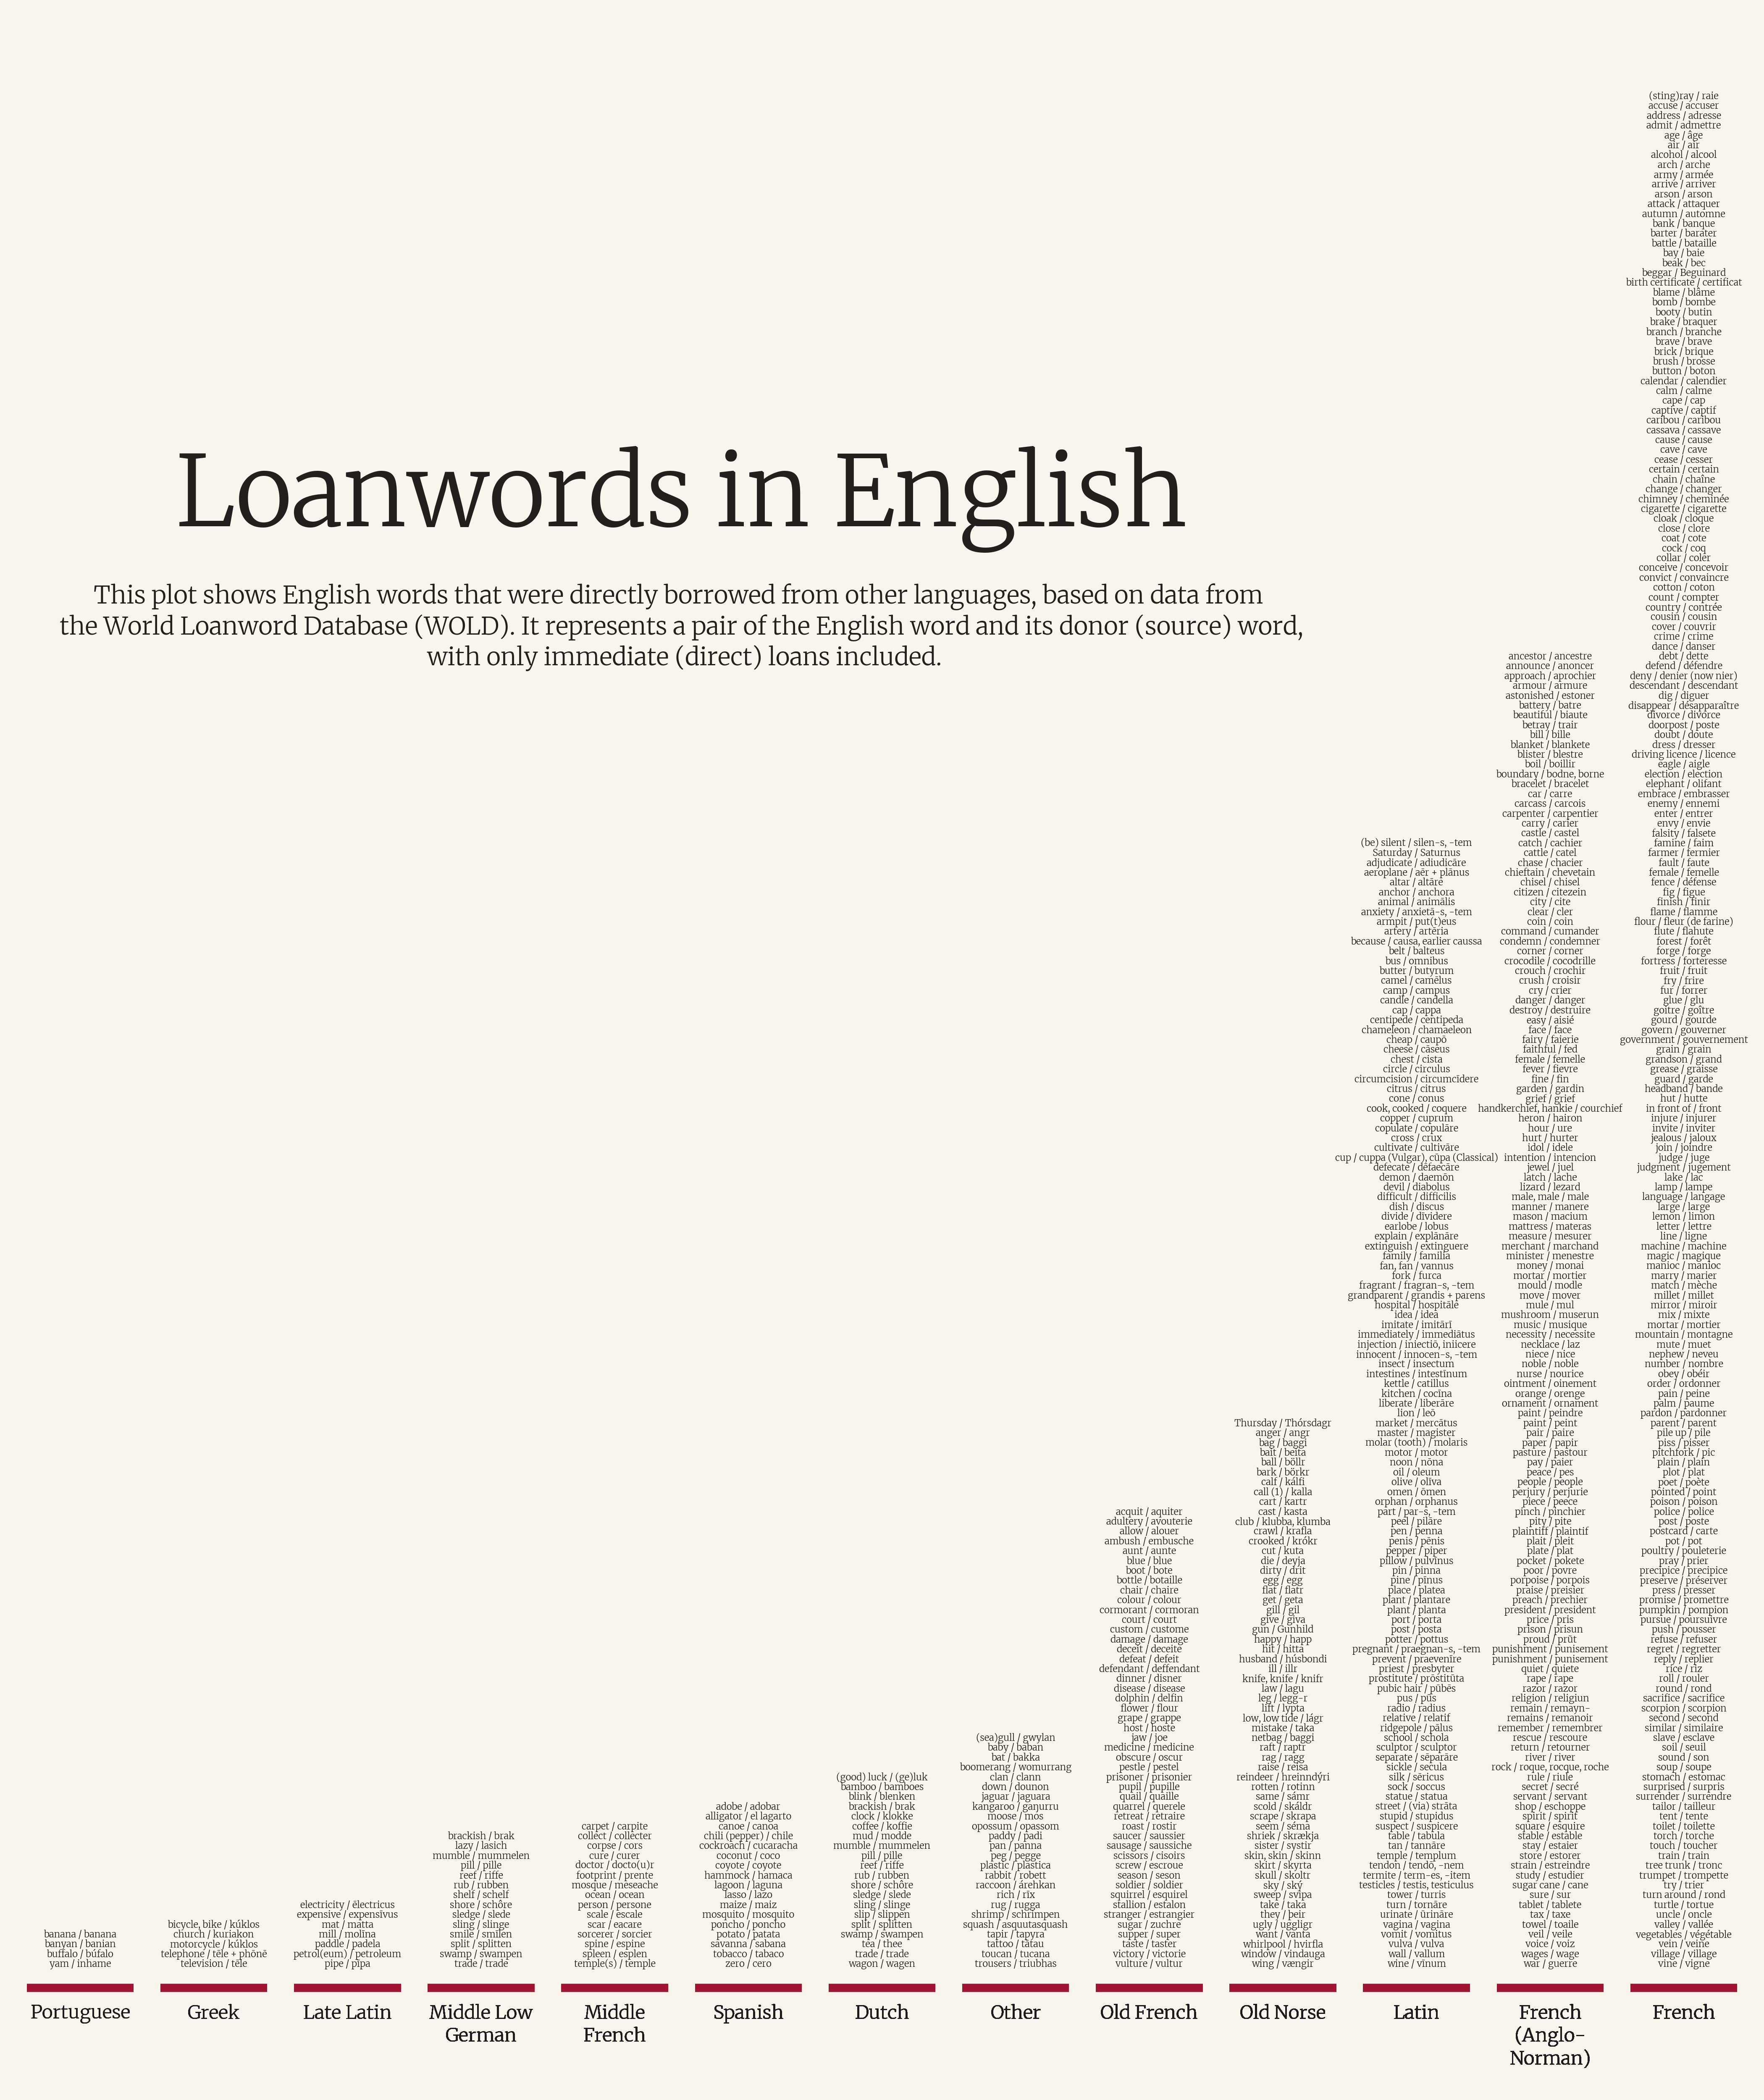

In [11]:

g = (
    p9.ggplot(data_all)
    # word/sourceword pair
    + p9.geom_text(
        p9.aes(
            x='source_language_lumped',
            y='y',
            label='word_form_source'
        ),
        size=8,
        ha='center',
            color='#221F1D',
        family=font_name,
    )
    # Using geom_crossbar to draw the lines/segments. 
    + p9.geom_crossbar(
        p9.aes(
            x='source_language_lumped',
            y='y_pos',         # The y-position for the line
            ymin='y_pos',      # Set ymin to y_pos
            ymax='y_pos'       # Set ymax to y_pos to create a flat line
        ),
        data=crossbar_data,
        width=0.8,             
        size=2,
        color='#9F1431'
    )
    # custom x axis
    + p9.geom_text(
        p9.aes(
            x='source_language_lumped',
            y=-3,
            label='source_language_lumped'
        ),
        family=font_name,
        color='#1E191A',
        ha = 'center',
        va = 'top',
        size=16,
        fontweight = 'bold'
        
    )
    #custom title
    + p9.annotate(
        "text",
        x=5.5,                
        y=150,                
        label="Loanwords in English", # The text you want to display
        size=84,
        ha='center',           # Horizontal alignment to the left
        color='#221F1D',
        family=font_name
    ) 
    #custom subtitle
    + p9.annotate(
        "text",
        x=5.5,                 
        y=137,                
        label="This plot shows English words that were directly borrowed from other languages, based on data from \nthe World Loanword Database (WOLD). It represents a pair of the English word and its donor (source) word,\n with only immediate (direct) loans included.", # The text you want to display
        size=21,
        ha='center',           # Horizontal alignment to the left
        color='#221F1D',
        family=font_name
    ) 
    + p9.scale_y_continuous(expand=(0.05, 0.1))
    + p9.theme_void(base_family=font_name)
    + p9.theme(
        plot_title=p9.element_text(
            ha='center',
            size=12,
            margin={'t': 40, 'b': -40}
        ),
        plot_background=p9.element_rect(fill="#F9F4EC", color="#F9F4EC"),
        figure_size=(21, 25),
        legend_position='none'
    )
)
g

In [12]:
g.save(filename="../plot/loanwords_plot.pdf", width=21, height=25, units="in")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 21 x 25 in image.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../plot/loanwords_plot.pdf


In [13]:
g.save(filename="../plot/loanwords_plot.png", width=21, height=25, units="in")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 21 x 25 in image.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../plot/loanwords_plot.png
